In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


100%|██████████| 9912422/9912422 [00:19<00:00, 512051.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1826698.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2074109.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1895386.41it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


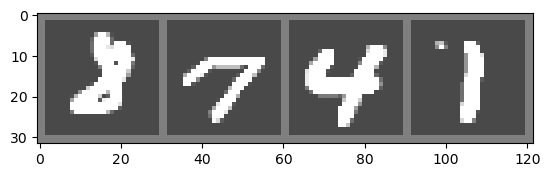

ship  horse deer  car  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [4]:
import torch_directml
# select the GPU device if available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch_directml.is_available():
    device = torch_directml.device(torch_directml.default_device())
else:
    device = torch.device("cpu")

In [ ]:
import torch
import torch.nn as nn

In [9]:
class NetTransformer(nn.Module):
    def __init__(self):
        super(NetTransformer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=28*28, nhead=4, dim_feedforward=28*28), num_layers=1)
        self.class_pred = nn.Linear(28*28, 10)
        
    def forward(self, images):
        # Flatten images
        x = images.view(images.size(0), -1)  
        x = self.encoder(x)
        x = self.class_pred(x)
        return x

In [10]:
import torch.optim as optim

net = NetTransformer()
net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_params = sum(p.numel() for p in net.parameters())
num_params

In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.479
[1,  4000] loss: 1.355
[1,  6000] loss: 1.385
[1,  8000] loss: 1.304
[1, 10000] loss: 1.148
[1, 12000] loss: 1.113
[1, 14000] loss: 0.958
[2,  2000] loss: 0.837
[2,  4000] loss: 0.806
[2,  6000] loss: 0.719
[2,  8000] loss: 0.689
[2, 10000] loss: 0.707
[2, 12000] loss: 0.647
[2, 14000] loss: 0.656
Finished Training


In [12]:
PATH = './mnist_transformer_unpatched.pth'
torch.save(net.state_dict(), PATH)

In [20]:
classes = (
    'Zero',   
    'One',    
    'Two',   
    'Three',  
    'Four',    
    'Five', 
    'Six',  
    'Seven',  
    'Eight',   
    'Nine'  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


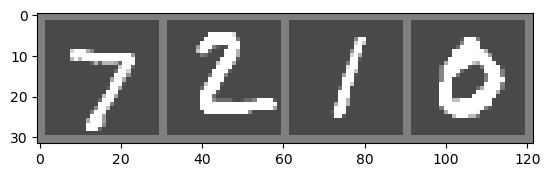

GroundTruth:  Seven Two   One   Zero 


In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j].item()]:5s}' for j in range(4)))

In [23]:
net = NetTransformer()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Seven Two   One   Zero 


In [26]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 84 %


In [27]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Zero  is 89.3 %
Accuracy for class: One   is 93.5 %
Accuracy for class: Two   is 79.7 %
Accuracy for class: Three is 86.0 %
Accuracy for class: Four  is 84.2 %
Accuracy for class: Five  is 81.3 %
Accuracy for class: Six   is 89.8 %
Accuracy for class: Seven is 87.4 %
Accuracy for class: Eight is 74.1 %
Accuracy for class: Nine  is 78.1 %
